In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

# # for creating a responsive plot
# %matplotlib ipympl
# %matplotlib widget

import  torch
import torch.nn.functional as F
'''
To get same results when sampling during different runs.
If you are using cuDNN, you should set the deterministic behavior.
This might make your code quite slow, but might be a good method to check your code and deactivate it later.
'''
torch.backends.cudnn.deterministic = True

In [2]:

words = open('names.txt', 'r').read().splitlines()

In [3]:
# sets takes an input, create a set of all items,
# & doesn't allow duplicates :)
# then we want a sorted list of course, the order matters! 
chars = sorted(list(set(''.join(words))))
# a map or dict:
# start from 1
s_to_i = { s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0
i_to_s = { i:s for s,i in s_to_i.items()}

In [4]:
import itertools
def plot_heatmap(tensor, text=True, nrow=None, ncol=None, fig_size=(10,10)):
    if (nrow is None) or (ncol is None):
        nrow = tensor.shape[0]
        ncol = tensor.shape[1]
    plt.figure(figsize=fig_size)
    plt.imshow(tensor.detach().numpy(), cmap= 'Blues')
    # manually write text on each cell (seaborn annot doesn't look good)
    if text:
        for i, j in itertools.product(range(nrow), range(ncol)):
            # x:col, y:rows, the origin is top left corner, makes bottom <->top
            plt.text(x=j, y=i, s=f'{tensor[i,j].item():.2f}', ha='center', va='center', color='grey')
    plt.axis('off')

### 2D & 3d Embedding Visualization

In [5]:
def plot_2d_emb(emb_lkt, nclass, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.scatter(x= emb_lkt[:,0].data, y=emb_lkt[:,1].data, s=200)
    for i in range(nclass):
        plt.text(x=emb_lkt[i,0].item(), y=emb_lkt[i,1].item(), s=i_to_s[i], ha='center', va='center', color='white')
    plt.grid('minor')

# def plot_3d_emb(emb_lkt, nclass, figsize=(8,8)):
#     tensor = emb_lkt.data.detach().numpy()
#     fig = plt.figure(figsize=figsize)
#     ax = Axes3D(fig)
#     ax.scatter(xs= tensor[:,0], ys=tensor[:,1], zs=tensor[:,2], s=200)
#     for i in range(nclass):
#         ax.text(x=tensor[i,0], y=tensor[i,1],z=tensor[i,2], s=i_to_s[i], ha='center', va='center', color='white')
#     # displaying the plot
#     plt.grid('minor')
#     plt.show()

## Splitting dataset into Training Dev & Test sets

1. split rate 80%, 10%, 10%

2. Dev or Validation set is for hyper parameter tuning

3. test should be touched at he end

In [6]:
WINDOW_SIZE = 5
NCLASS = 27

def build_dataset(words:list, type:str):
    xs, ys = [], []

    # context input window: how many characters do we take to predict the next one?
    

    for w in words:
        context_window = [0]*WINDOW_SIZE
        for ch in f'{w}.':
            idx_y = s_to_i[ch]
            ys.append(idx_y)

            xs.append(context_window) # input : ch1
            # print(''.join(i_to_s[i] for i in context_window) + f' ---> {ch}' )

            # shift_to_left context window and append the idx_y
            context_window = context_window[1:] + [idx_y]
    xs = torch.tensor(xs) # device= 'cuda'
    # ys = torch.Tensor(ys)
    ys = torch.tensor(ys)
    print(f'{type}: {xs.shape = }')
    return xs, ys


import random
random.seed(42)
random.shuffle(words)
n80 = int( 0.8*len(words) )
n90 = int( 0.9*len(words) )
Xtr, Ytr = build_dataset(words[:n80], 'Tr')
Xdev, Ydev = build_dataset(words[n80:n90], 'Dev')
Xts, Yts = build_dataset(words[n90:], 'Ts')
TR_SIZE = Xtr.shape[0]
DEV_SIZE = Xdev.shape[0]
TS_SIZE = Xts.shape[0]
print(f'{TR_SIZE = }')
print(f'{WINDOW_SIZE = }')
print(f'{NCLASS = }')

Tr: xs.shape = torch.Size([182625, 5])
Dev: xs.shape = torch.Size([22655, 5])
Ts: xs.shape = torch.Size([22866, 5])
TR_SIZE = 182625
WINDOW_SIZE = 5
NCLASS = 27


In [7]:
g = torch.Generator().manual_seed(2147483647)

# Motif Block
In NN architectures we usually have a stack of multiple similar blocks connected together. This block is composed of 3 layers: 

1. Linear or Matrix Multiplication

2. Batch Normalization

3. Activation function

In [8]:
class Module:
    def parameters(self):
        return []

## 1. Linear Layer

In [9]:
class Linear(Module):
    def __init__(self, fan_in, fan_out, bias=True, w_gain=1.0) -> None:
        # initialization
        self.w_gain = w_gain
        self.W = torch.randn(fan_in, fan_out, generator=g) / fan_in**0.5 # device= 'cuda'
        self.b = torch.zeros(fan_out) if bias else None # device= 'cuda'
    
    def __call__(self, x):
        self.out = x @ (self.w_gain * self.W)
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ( [] if self.b is None else [self.b] )

## 2. Batch Normalization Layer

In [10]:
class BatchNorm1d(Module):
    def __init__(self, fan_out, eps=1e-5, momentum=0.1, scale_gain=1.0, training=True) -> None:
        self.eps = eps
        self.momentum = momentum

        # flexible Gaussian preact
        self.scale = torch.ones(fan_out) # device= 'cuda'
        self.shift = torch.zeros(fan_out) # device= 'cuda'

        # use it just in case you want to use batch norm as logits before loss
        self.scale_gain = scale_gain

        self.training = training

        # Buffers (in PyTorch nomenclature)
        # ema of mean and std
        self.bn_mean_ema = torch.zeros(fan_out) # device= 'cuda'
        self.bn_std_ema = torch.ones(fan_out) # device= 'cuda'
    
    def __call__(self, x):
        if self.training:
            self.bn_mean = x.mean(dim=0, keepdim=True) # 1, HLAYER_SIZE
            self.bn_std = x.std(dim=0, keepdim=True) # 1, HLAYER_SIZE
            self.out = self.shift + self.scale_gain * self.scale * (x - self.bn_mean) / (self.bn_std + self.eps)

            # update moving stats
            with torch.no_grad():
                self.bn_mean_ema = (1 - self.momentum) * self.bn_mean_ema + self.momentum * self.bn_mean
                self.bn_std_ema = (1 - self.momentum) * self.bn_std_ema + self.momentum * self.bn_std
        else:
            with torch.no_grad():
                self.out = self.shift + self.scale * (x - self.bn_mean_ema) / (self.bn_std_ema + self.eps)
        return self.out
    
    def parameters(self):
        return [self.scale, self.shift]

# 3. Activation Function

In [11]:
class Tanh(Module):

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

# Building model Sequentially

## without Batch Norm

In [136]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g) # device= 'cuda'

# MLP layers without Batch Norm and logits
layers = [
    Linear(fan_in=WINDOW_SIZE*EMB_DIM, fan_out=HLAYER_SIZE, bias=True),    Tanh(),
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=True),     Tanh(),
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=True),     Tanh(),
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=True),     Tanh()
]

# The recommended Gain for weight initialization of all
# Motif Blocks based on the activation
with torch.no_grad():
    for layer in layers:
        if isinstance(layer, Linear):
            layer.w_gain = 1/3

# add logits layer with low weight gain to make it less confident
layers.append(Linear(fan_in=HLAYER_SIZE, fan_out=NCLASS, bias=True, w_gain=0.1) )

parameters = [emb_lkt] + [ p for layer in layers for p in layer.parameters() ]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

286962

**`to better debug our model, we need to keep track of changes in the distribution of activations and parameters' value and gradients`**

we also pay attention to the 2 ratios in parameters:
- (gradient std) / (data std):

        gives you a sense of what is the range or scale of the gradient compared to the range or scale of the actual parameters, and it's important bc
        we're going to update the parameters with the gradients, so we wanna the relative ratio.

- (real updates) / (data std) in multiple iterations:

    In this one, we also consider the lr effect.  

In [137]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

upd_param_ratio = []

for i in range(NSTEPS):
    batch_upd_param_ratio = []
    
    # Mini batch construct
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,)) # device= 'cuda'
    batch_emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    x= batch_emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)
    
    # Forward pass
    for layer in layers:
        x = layer(x)
    
    batch_loss = F.cross_entropy(x, Ytr[mini_batch_idx])
    lossi.append(batch_loss.log10().item())
    stepi.append(i)

    # Backward pass
    for layer in layers:
        # keep track of grads for DEBUGGING
        layer.out.retain_grad() # AFTER DEDBUG: would take out retain_grad

    for p in parameters:
        p.grad = None
    batch_loss.backward()

    # update &
    for p in parameters:
        p.data -= lr*p.grad
    
    with torch.no_grad():
        upd_param_ratio.append( [(lr*p.grad.std() / p.data.std()).item() for p in parameters ] ) # DEBUG_ITERS * NPARAMS

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {batch_loss.item():.4f}')
    
    break # intentionally added, AFTER DEBUG, would take out obviously to run full optimization


iteration:       0 /  100000 | mini loss: 3.2955


## Visualization

layer 0: Linear | mean : -0.01 | std : 0.32
layer 2: Linear | mean : -0.00 | std : 0.10
layer 4: Linear | mean : 0.00 | std : 0.03
layer 6: Linear | mean : -0.00 | std : 0.01


Text(0.5, 1.0, 'Linear pre-activation Distributions')

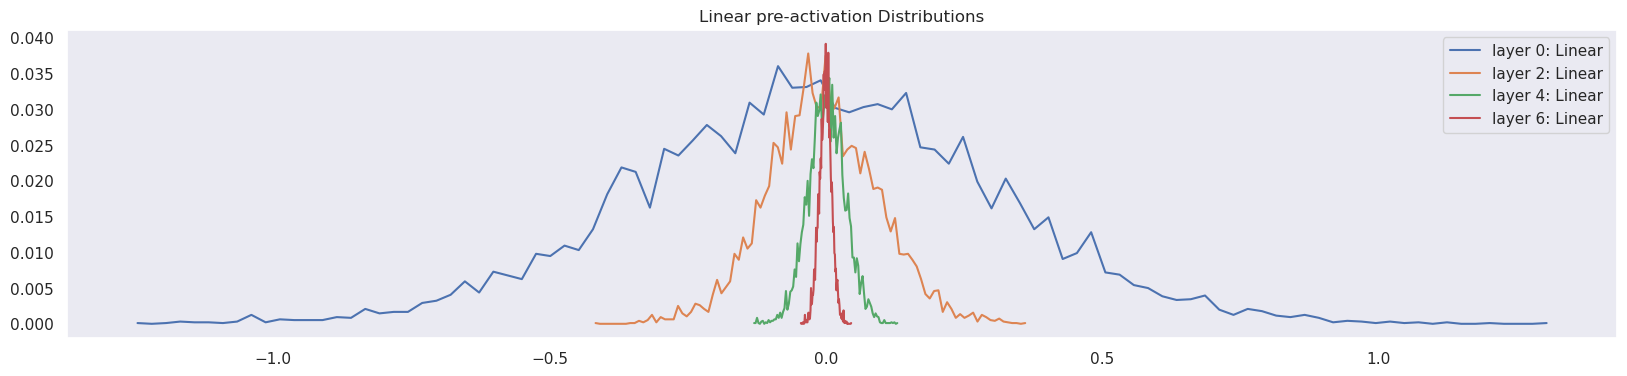

In [138]:
# visualize the Linear pre-activation distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Linear):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Linear pre-activation Distributions')

layer 1: Tanh | mean : -0.01 | std : 0.29 | saturated : 0.00
layer 3: Tanh | mean : -0.00 | std : 0.10 | saturated : 0.00
layer 5: Tanh | mean : 0.00 | std : 0.03 | saturated : 0.00
layer 7: Tanh | mean : -0.00 | std : 0.01 | saturated : 0.00


Text(0.5, 1.0, 'Activation Distributions')

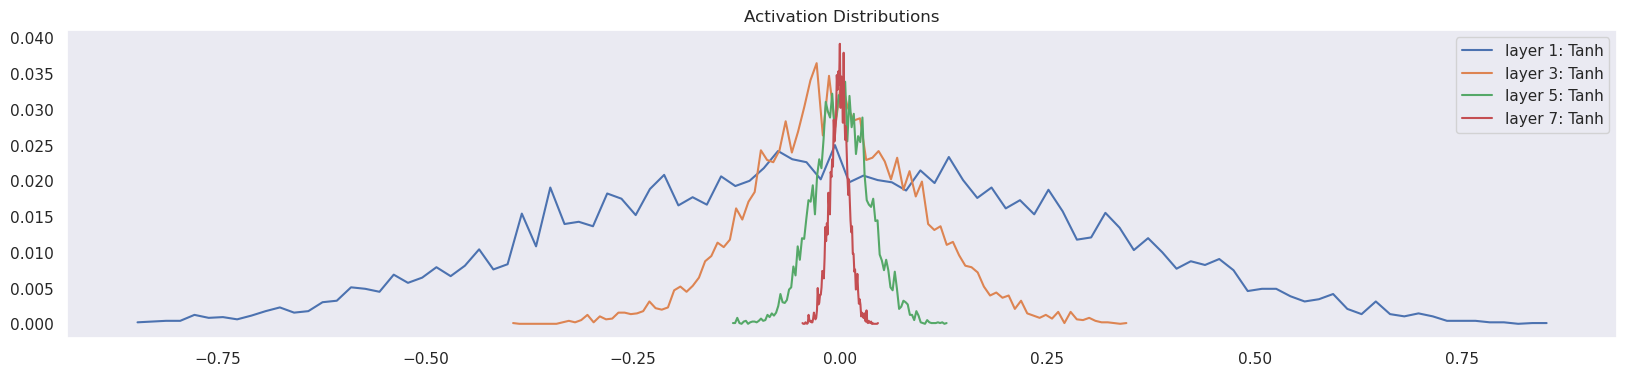

In [139]:
# visualize the Activation distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f} | saturated : {(t.abs() > 0.97).float().mean()*100:.2f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation Distributions')

**`Our X input are Normal, and we have already controlled Matrix Multiplication Gaussianizing effect by dividing the weight by roo2(fan_in) to also have a normal Gaussain in the output of the linear layer or pre-activation. Note: if the input is not normal we need another coefficient, so make it normal!!!`**

but now we have tanh a non-linear function, with the gradients between (0,1] (shrinks the input). so we need to uplift the weights a little bit to compensate for the shrinkage:

- if we compensate less than enough (5/3) we will get narrower than a Normal in the input of the next layer, and the next Linear layer (Matrix Multiplication) will need another (higher) gain to make the output normal. otherwise the 2nd Linear will generate a narrower Gaussian with less extreme values or saturated Neurons (less blocked or 0 gradient -> a wider Gaussian Gradient Distribution), and give it to the next layer and so on.

- if we compensate more than enough we will get wider than a Normal in the input of the next layer, and the next Linear layer (Matrix Multiplication) will need another (lower) gain to make the output normal. otherwise the 2nd Linear will generate a wider Gaussian with more extreme values or saturated Neurons (more blocked or 0 gradient -> a narrower Gaussian Gradient Distribution), and give it to the next layer and so on.

layer 0: Linear | mean : 0.00000003 | std : 0.00000584
layer 2: Linear | mean : -0.00000035 | std : 0.00001879
layer 4: Linear | mean : 0.00000064 | std : 0.00005823
layer 6: Linear | mean : -0.00000099 | std : 0.00017629


Text(0.5, 1.0, 'Activation Gradient Distributions')

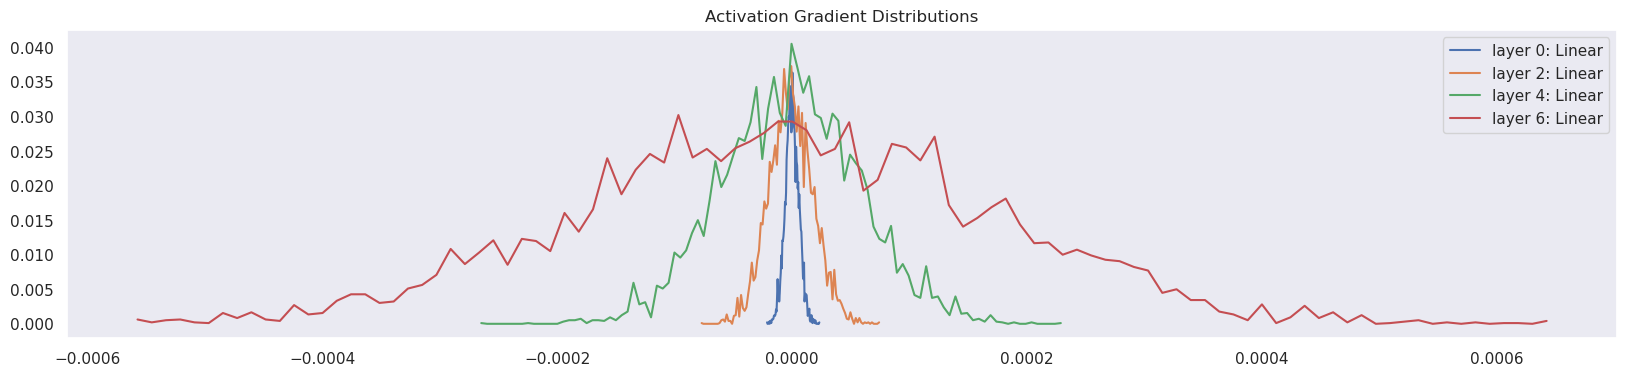

In [140]:
# visualize the Activation Gradient distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Linear):
        t = layer.out.grad # remember when we called retain_grad
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.8f} | std : {t.std():.8f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation Gradient Distributions')


weight: (27, 5) | grad mean : 0.00000399 | grad std : 0.00001766 | grad:data ratio : 1.7063330233213492e-05
weight: (25, 300) | grad mean : 0.00000015 | grad std : 0.00001344 | grad:data ratio : 6.73013273626566e-05
weight: (300, 300) | grad mean : -0.00000004 | grad std : 0.00001313 | grad:data ratio : 0.00022723388974554837
weight: (300, 300) | grad mean : -0.00000005 | grad std : 0.00001406 | grad:data ratio : 0.000242864407482557
weight: (300, 300) | grad mean : -0.00000010 | grad std : 0.00001457 | grad:data ratio : 0.00025309144984930754
weight: (300, 27) | grad mean : 0.00000000 | grad std : 0.00004899 | grad:data ratio : 0.0008533670916222036


Text(0.5, 1.0, 'Parameters Gradient Distributions')

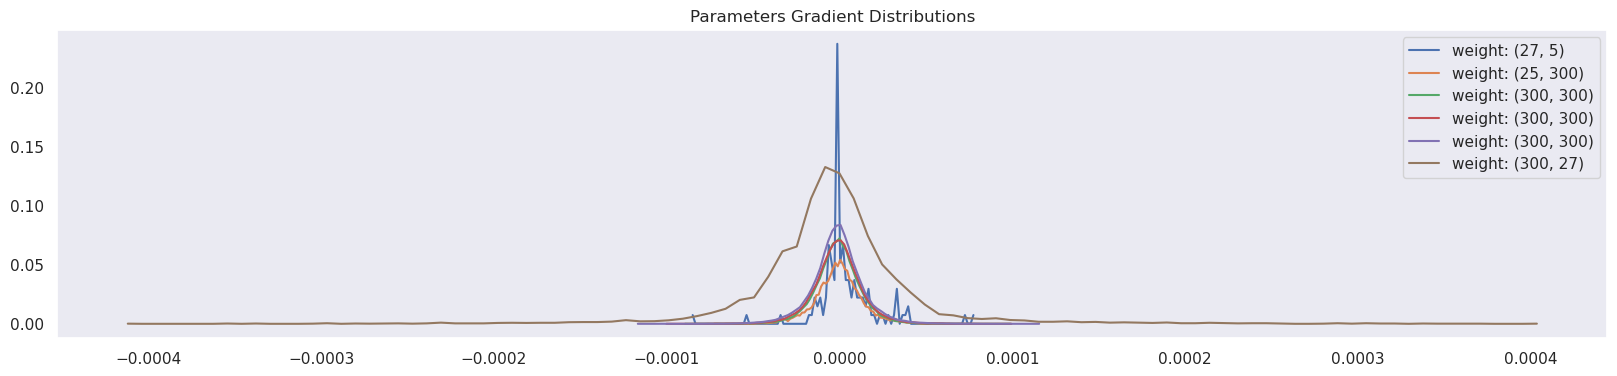

In [141]:
# visualize the parameter Gradient distributions
plt.figure(figsize=(20, 4))
legends = []

for p in parameters:
     # for simpilicity, just looking at 2d parameters meaning W in Linear
     # so skip bias, bn_shift, bn_scale
    if p.ndim == 2:
        t = p.grad
        print(f'weight: {tuple(p.shape)} | grad mean : {t.mean():.8f} | grad std : {t.std():.8f} | grad:data ratio : {t.std()/p.std()}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'weight: {tuple(p.shape)}')
plt.legend(legends)
plt.title('Parameters Gradient Distributions')

here we see that the last Linear logits layer, has much more (3x to 10x) grad:data ratio.

this is problematic, bc this means that the SGD update steps for this layer is 3x to 10x faster than other layers at initialization. but we wanna train the whole layers with same speed.

After some iterations, this will resolved by itself, but let's track updates for multiple iterations:

- (real updates) / (data std) in multiple iterations:

    In this one, we also consider the lr effect.  

## Visualize after training Iterations

In [80]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g) # device= 'cuda'

# MLP layers without Batch Norm and logits
layers = [
    Linear(fan_in=WINDOW_SIZE*EMB_DIM, fan_out=HLAYER_SIZE, bias=True),    Tanh(),
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=True),     Tanh(),
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=True),     Tanh(),
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=True),     Tanh()
]

# The recommended Gain for weight initialization of all
# Motif Blocks based on the activation
with torch.no_grad():
    for layer in layers:
        if isinstance(layer, Linear):
            layer.w_gain = 5/3

# add logits layer with low weight gain to make it less confident
layers.append(Linear(fan_in=HLAYER_SIZE, fan_out=NCLASS, bias=True, w_gain=0.1) )

parameters = [emb_lkt] + [ p for layer in layers for p in layer.parameters() ]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

286962

In [81]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

DEBUG_ITERS = 1000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []
upd_param_ratio = []

for i in range(NSTEPS):
    
    # Mini batch construct
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,)) # device= 'cuda'
    batch_emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    x= batch_emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)
    
    # Forward pass
    for layer in layers:
        x = layer(x)
    
    batch_loss = F.cross_entropy(x, Ytr[mini_batch_idx])
    lossi.append(batch_loss.log10().item())
    stepi.append(i)

    # Backward pass
    for layer in layers:
        # keep track of grads for DEBUGGING
        layer.out.retain_grad() # AFTER DEDBUG: would take out retain_grad

    for p in parameters:
        p.grad = None
    batch_loss.backward()

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        # p.grad = None
    
    with torch.no_grad():
        upd_param_ratio.append( [(lr*p.grad.std() / p.data.std()).item() for p in parameters ] ) # DEBUG_ITERS * NPARAMS
    
    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {batch_loss.item():.4f}')
    
    if i > DEBUG_ITERS: 
        break # intentionally added, AFTER DEBUG, would take out obviously to run full optimization


iteration:       0 /  100000 | mini loss: 3.3113


layer 0: Linear | mean : -0.08 | std : 1.84
layer 2: Linear | mean : -0.00 | std : 1.65
layer 4: Linear | mean : 0.16 | std : 1.68
layer 6: Linear | mean : 0.13 | std : 2.13


Text(0.5, 1.0, 'Linear pre-activation Distributions')

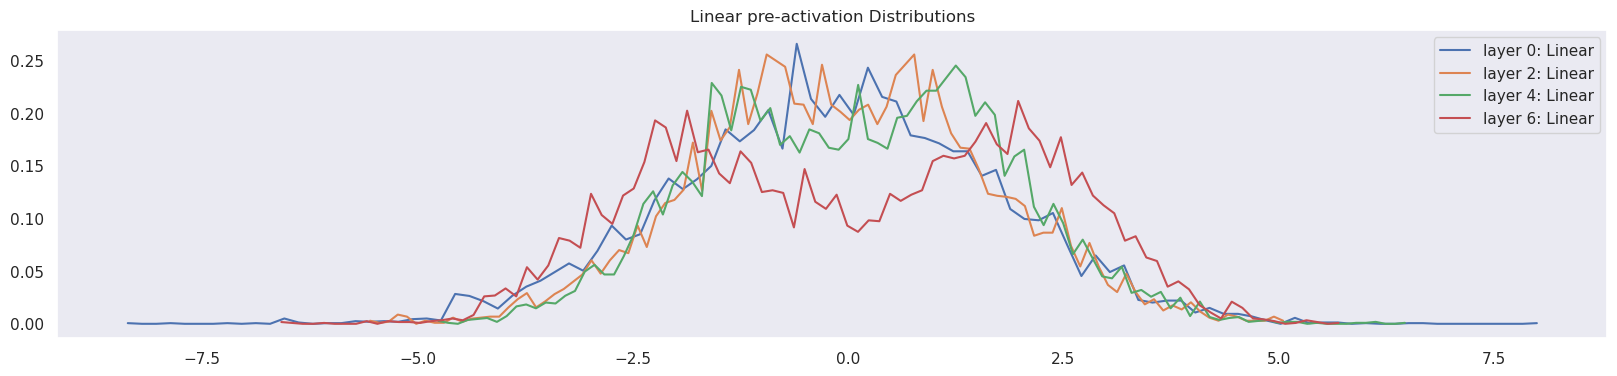

In [82]:
# visualize the Linear pre-activation distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Linear):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Linear pre-activation Distributions')

layer 1: Tanh | mean : -0.03 | std : 0.78 | saturated : 25.39
layer 3: Tanh | mean : -0.01 | std : 0.77 | saturated : 20.60
layer 5: Tanh | mean : 0.06 | std : 0.79 | saturated : 21.68
layer 7: Tanh | mean : 0.04 | std : 0.87 | saturated : 40.59


Text(0.5, 1.0, 'Activation Distributions')

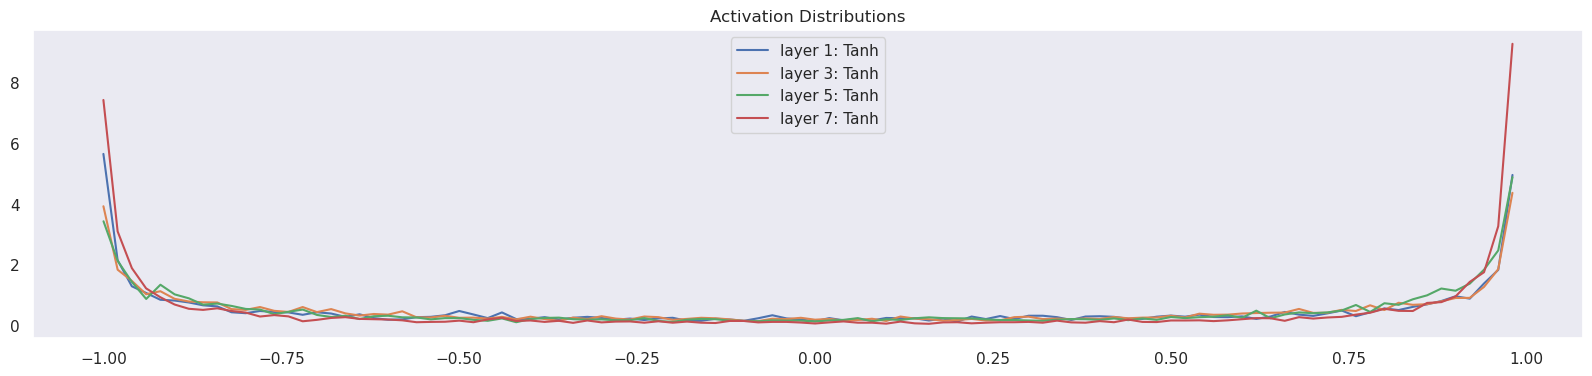

In [83]:
# visualize the Activation distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f} | saturated : {(t.abs() > 0.97).float().mean()*100:.2f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation Distributions')

Here we can see that after a number of iterations we get more & more saturated neurons. It's not good.

layer 0: Linear | mean : 0.00000124 | std : 0.00021546
layer 2: Linear | mean : 0.00000234 | std : 0.00018577
layer 4: Linear | mean : -0.00000247 | std : 0.00014251
layer 6: Linear | mean : -0.00000051 | std : 0.00010659


Text(0.5, 1.0, 'Activation Gradient Distributions')

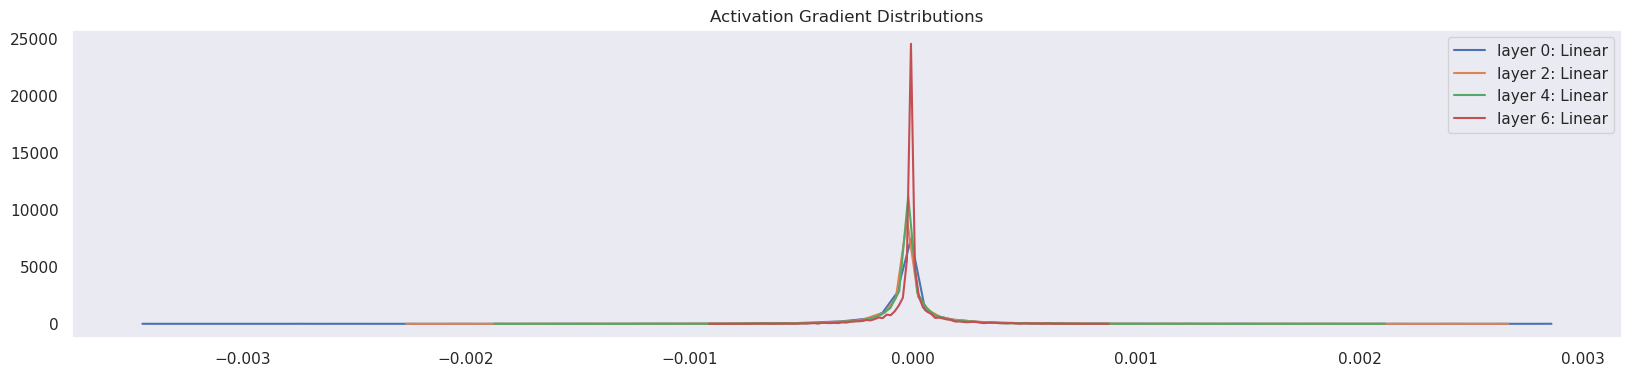

In [84]:
# visualize the Activation Gradient distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Linear):
        t = layer.out.grad # remember when we called retain_grad
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.8f} | std : {t.std():.8f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation Gradient Distributions')


weight: (27, 5) | grad mean : -0.00042990 | grad std : 0.00472001 | grad:data ratio : 0.0045681726187467575
weight: (25, 300) | grad mean : 0.00000285 | grad std : 0.00202421 | grad:data ratio : 0.01013198308646679
weight: (300, 300) | grad mean : -0.00000539 | grad std : 0.00129252 | grad:data ratio : 0.022262688726186752
weight: (300, 300) | grad mean : -0.00000201 | grad std : 0.00096186 | grad:data ratio : 0.01651889458298683
weight: (300, 300) | grad mean : 0.00000138 | grad std : 0.00082874 | grad:data ratio : 0.014233564026653767
weight: (300, 27) | grad mean : 0.00000000 | grad std : 0.00354738 | grad:data ratio : 0.04402586445212364


Text(0.5, 1.0, 'Parameters Gradient Distributions')

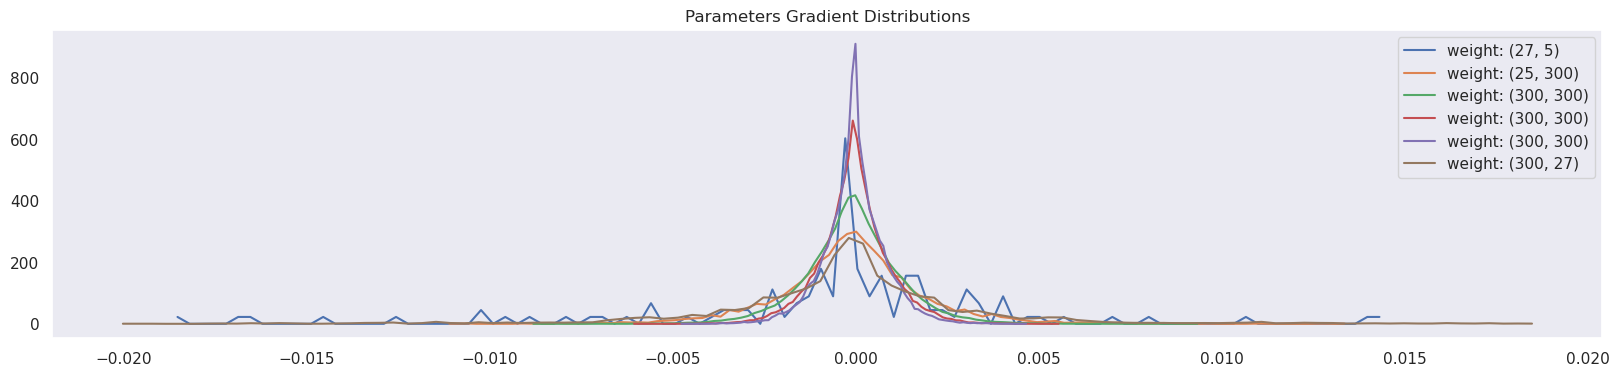

In [85]:
# visualize the parameter Gradient distributions
plt.figure(figsize=(20, 4))
legends = []

for p in parameters:
     # for simpilicity, just looking at 2d parameters meaning W in Linear
     # so skip bias, bn_shift, bn_scale
    if p.ndim == 2:
        t = p.grad
        '''
        (gradient std) / (data std):
        gives you a sense of what is the range or scale of
        the gradient compared to the range or scale of the
        actual parameters, and it's important bc
        we're going to update the parameters with the gradients
        so we wanna the steps are large, enough or small
        '''
        print(f'weight: {tuple(p.shape)} | grad mean : {t.mean():.8f} | grad std : {t.std():.8f} | grad:data ratio : {t.std()/p.std()}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'weight: {tuple(p.shape)}')
plt.legend(legends)
plt.title('Parameters Gradient Distributions')

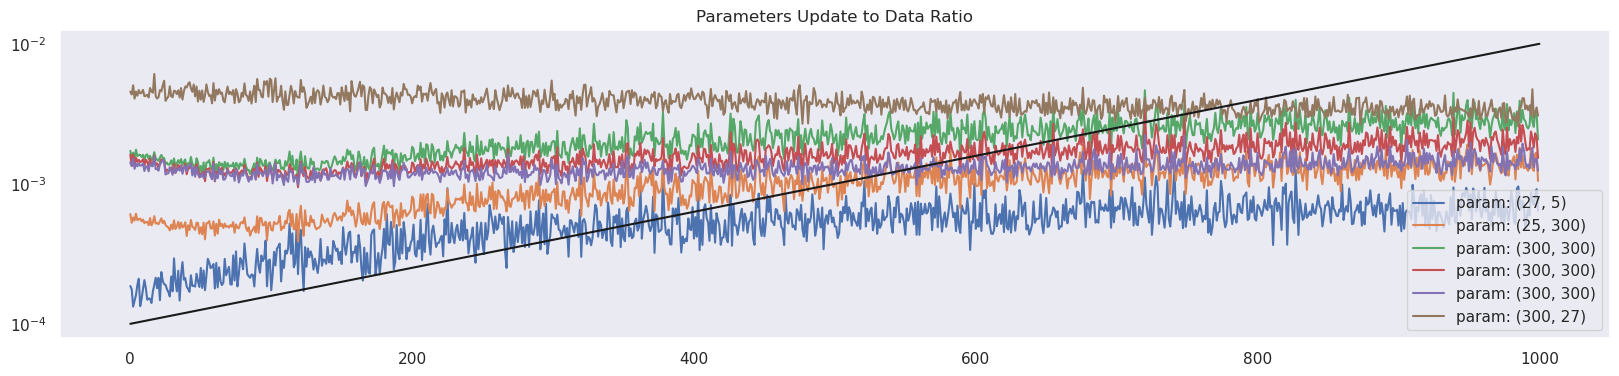

In [86]:
# visualize the update to parameters ratio
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
     # for simpilicity, just looking at 2d parameters meaning W in Linear
     # so skip bias, bn_shift, bn_scale
    if p.ndim == 2:
        # NSTEPS * NPARAMS
        plt.semilogy( [upd_param_ratio[j][i] for j in range(DEBUG_ITERS)] )
        legends.append(f'param: {tuple(p.shape)}')
plt.semilogy([0, DEBUG_ITERS], [1e-4, 1e-2], 'k') # these ratios should be around ~1e-3, plot this black line to indicate on plot
plt.legend(legends)
plt.title('Parameters Update to Data Ratio')
plt.show()

The recommended update to data ratio for parameters is around 1e-3

if it was 0.1, it means the weights are undergoing a relatively large change.

The reason the last layer (logits) has a larger update ratio is that we had shrunk down the parameter data manually by 0.1 factor, but still the update ratio is below 0.01 and it's decreasing.

if the ratio is below 1e-3 it means that the parameters are not learning fast enough.

Try some miscalibration scenarios like wrong gain and see the plots and compare it with a calibrated one

## Adding Batch Norm

let's place the Batch Norm between Linear and Activation layer.

Andrej said ppl also have played with putting it after activation, you would fairly same results!

In [22]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g) # device= 'cuda'

# MLP layers with Batch Norm
layers = [
    Linear(fan_in=WINDOW_SIZE*EMB_DIM, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-6, momentum=0.001),
    Tanh(),

    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-6, momentum=0.001),
    Tanh(),
    
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-6, momentum=0.001),
    Tanh(),
    
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-6, momentum=0.001),
    Tanh(),
]

# The recommended Gain for weight initialization of all
# Motif Blocks based on the activation
with torch.no_grad():
    for layer in layers:
        if isinstance(layer, Linear):
            layer.w_gain = 5/3
        if isinstance(layer, BatchNorm1d):
            layer.training = True

# add logits layer with low weight gain to make it less confident
layers.append(Linear(fan_in=HLAYER_SIZE, fan_out=NCLASS, bias=True, w_gain=0.1) )
# layers.append(BatchNorm1d(fan_out=NCLASS, scale_gain=0.1) )



parameters = [emb_lkt] + [ p for layer in layers for p in layer.parameters() ]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

288162

In [23]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

DEBUG_ITERS = NSTEPS

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []
upd_param_ratio = []

for i in range(NSTEPS):
    
    # Mini batch construct
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,)) # device= 'cuda'
    batch_emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    x= batch_emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)
    
    # Forward pass
    for layer in layers:
        x = layer(x)
    
    batch_loss = F.cross_entropy(x, Ytr[mini_batch_idx])
    lossi.append(batch_loss.log10().item())
    stepi.append(i)

    # Backward pass
    for layer in layers:
        # keep track of grads for DEBUGGING
        layer.out.retain_grad() # AFTER DEDBUG: would take out retain_grad

    for p in parameters:
        p.grad = None
    batch_loss.backward()

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        # p.grad = None
    
    with torch.no_grad():
        upd_param_ratio.append( [(lr*p.grad.std() / p.data.std()).item() for p in parameters ] ) # DEBUG_ITERS * NPARAMS
    
    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {batch_loss.item():.4f}')
    
    if i > DEBUG_ITERS: 
        break # intentionally added, AFTER DEBUG, would take out obviously to run full optimization


iteration:       0 /  100000 | mini loss: 3.2745
iteration:   10000 /  100000 | mini loss: 2.3557
iteration:   20000 /  100000 | mini loss: 2.6836
iteration:   30000 /  100000 | mini loss: 2.0163
iteration:   40000 /  100000 | mini loss: 1.7298
iteration:   50000 /  100000 | mini loss: 1.6701
iteration:   60000 /  100000 | mini loss: 2.1202
iteration:   70000 /  100000 | mini loss: 1.7910
iteration:   80000 /  100000 | mini loss: 2.0537
iteration:   90000 /  100000 | mini loss: 2.3536


In [24]:
@torch.no_grad()
def evaluate_loss(ds_type): # ds_type: dataset type
    X,Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[ds_type]

    emb = emb_lkt[X] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    x = emb.view(-1, WINDOW_SIZE*EMB_DIM)
    
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
    
    # Forward pass
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Y)
    print(f'{ds_type} loss: {loss.item()}')

In [25]:
evaluate_loss('train')
evaluate_loss('dev')

train loss: 1.9094902276992798
dev loss: 2.03670072555542


**`The best result ever!!!!`**

In [26]:
# rolling mean and std are almost equal to the exact value
@torch.no_grad()
def compare_ema(emb_lkt):
    emb = emb_lkt[Xtr] # DATASET_SIZE, WINDOW_SIZE, EMD_DIM
    x = emb.view(-1, WINDOW_SIZE*EMB_DIM)

    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
    
    for i, layer in enumerate(layers):
        print(f'layer {i}: {layer.__class__.__name__}')
        x = layer(x)
        if isinstance(layer, BatchNorm1d):
            bn_mean = x.mean(dim=0, keepdim=True)
            bn_std = x.std(dim=0, keepdim=True)
            print((bn_mean - layer.bn_mean_ema).mean(), (bn_mean - layer.bn_mean_ema).std() )
            print((bn_std - layer.bn_std_ema).mean(), (bn_std - layer.bn_std_ema).std() )

# going into local scale parameters to not change the global ones
compare_ema(emb_lkt)

layer 0: Linear
layer 1: BatchNorm1d
tensor(0.0581) tensor(1.4641)
tensor(-0.4888) tensor(0.1927)
layer 2: Tanh
layer 3: Linear
layer 4: BatchNorm1d
tensor(-0.0682) tensor(0.4339)
tensor(-2.4854) tensor(0.4871)
layer 5: Tanh
layer 6: Linear
layer 7: BatchNorm1d
tensor(0.0311) tensor(0.5229)
tensor(-2.0598) tensor(0.4707)
layer 8: Tanh
layer 9: Linear
layer 10: BatchNorm1d
tensor(-0.0109) tensor(0.6179)
tensor(-0.7043) tensor(0.3011)
layer 11: Tanh
layer 12: Linear


if the difference in any layer is higher than 0.5 we need a lower momentum

layer 0: Linear | mean : -0.03 | std : 2.39
layer 3: Linear | mean : 0.10 | std : 4.14
layer 6: Linear | mean : -0.03 | std : 3.62
layer 9: Linear | mean : 0.03 | std : 2.63


Text(0.5, 1.0, 'Linear pre-activation Distributions')

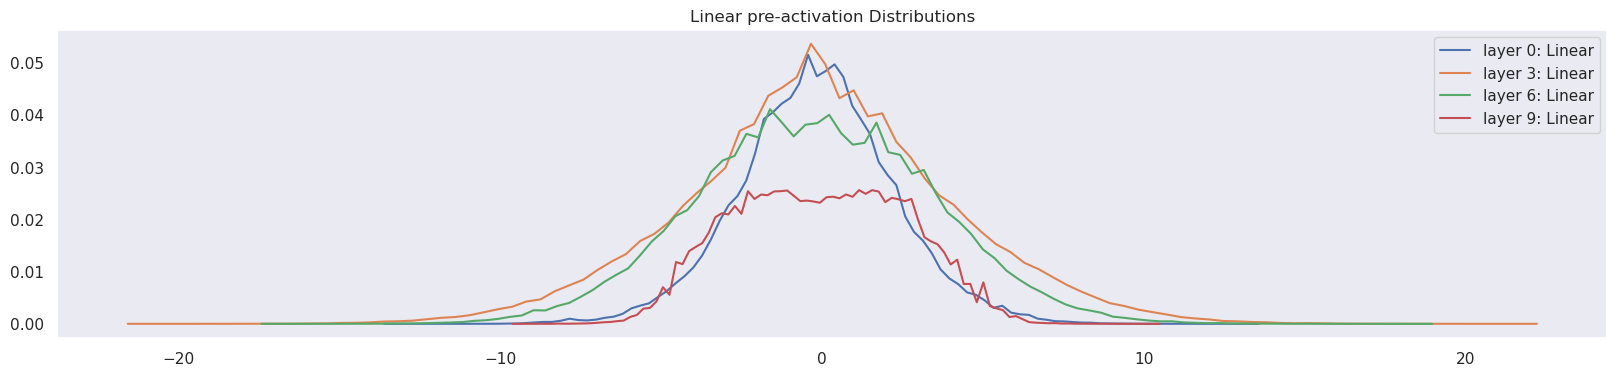

In [27]:
# visualize the Linear pre-activation distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Linear):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Linear pre-activation Distributions')

layer 1: BatchNorm1d | mean : 0.02 | std : 1.53
layer 4: BatchNorm1d | mean : 0.03 | std : 1.64
layer 7: BatchNorm1d | mean : -0.02 | std : 1.53
layer 10: BatchNorm1d | mean : 0.01 | std : 1.78


Text(0.5, 1.0, 'Batch Norm output Distributions')

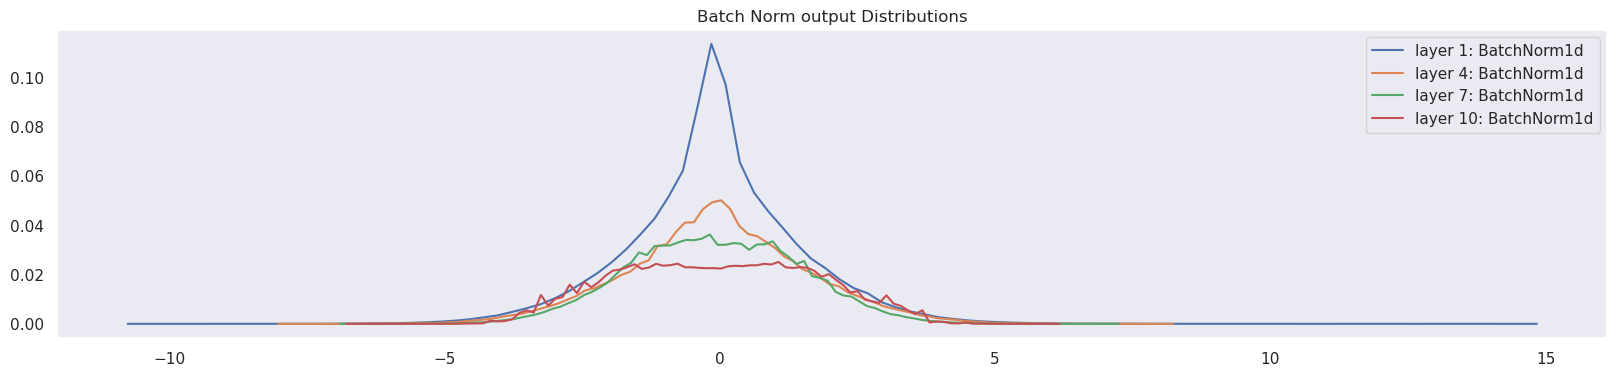

In [28]:
# visualize the Batch Norm output distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, BatchNorm1d):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Batch Norm output Distributions')

layer 2: Tanh | mean : 0.01 | std : 0.69 | saturated : 16.60
layer 5: Tanh | mean : 0.01 | std : 0.74 | saturated : 20.19
layer 8: Tanh | mean : -0.01 | std : 0.75 | saturated : 16.93
layer 11: Tanh | mean : 0.00 | std : 0.81 | saturated : 26.82


Text(0.5, 1.0, 'Activation Distributions')

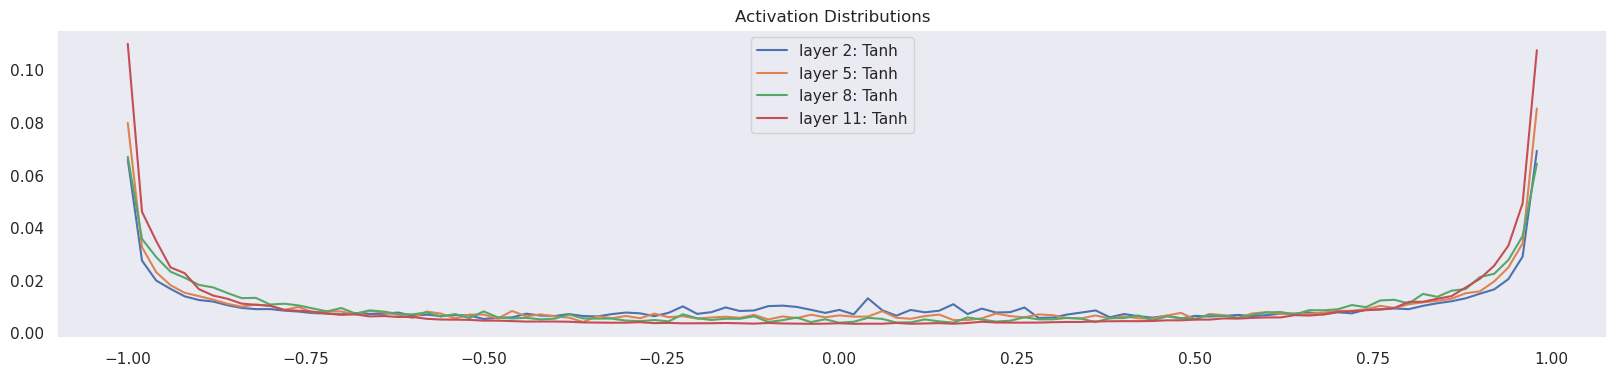

In [29]:
# visualize the Activation distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f} | saturated : {(t.abs() > 0.97).float().mean()*100:.2f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation Distributions')

Woow!!, without BatchNorm, after 1K iteration, we had around 20-30% saturated neurons

But now with Batch Norm, we only have 2-3 % of those. 10 x improvement with same std

In [38]:
# visualize the Activation Gradient distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    print(f'layer {i}: {layer.__class__.__name__}')
    if isinstance(layer, Linear):
        t = layer.out.grad # remember when we called retain_grad
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.8f} | std : {t.std():.8f}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation Gradient Distributions')


layer 0: BatchNorm1d
layer 1: Tanh
layer 2: Linear


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

In [37]:
print(layer.out.grad)

None


It's not good, we get narrower gaussians (more saturated neurons) layer by lyaer

weight: (27, 5) | grad mean : 0.00000000 | grad std : 0.01887165 | grad:data ratio : 0.015951387584209442
weight: (25, 300) | grad mean : 0.00005466 | grad std : 0.00562024 | grad:data ratio : 0.019705086946487427
weight: (300, 300) | grad mean : -0.00000613 | grad std : 0.00241941 | grad:data ratio : 0.022744204849004745
weight: (300, 300) | grad mean : 0.00000565 | grad std : 0.00237158 | grad:data ratio : 0.023400291800498962
weight: (300, 300) | grad mean : -0.00000076 | grad std : 0.00183330 | grad:data ratio : 0.021342085674405098
weight: (300, 27) | grad mean : -0.00000000 | grad std : 0.00243050 | grad:data ratio : 0.007802367210388184


Text(0.5, 1.0, 'Parameters Gradient Distributions')

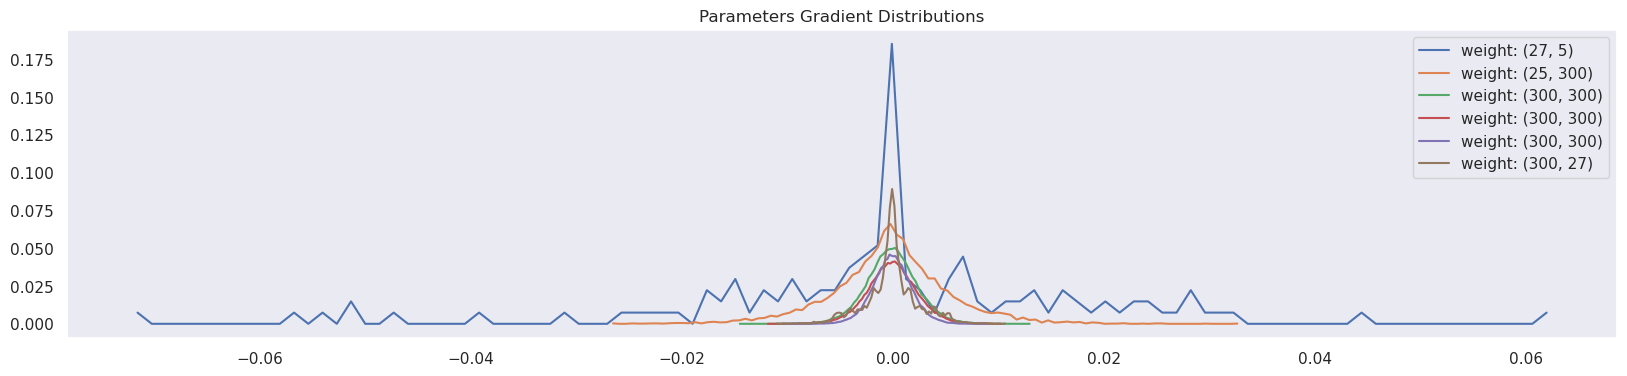

In [31]:
# visualize the parameter Gradient distributions
plt.figure(figsize=(20, 4))
legends = []

for p in parameters:
     # for simpilicity, just looking at 2d parameters meaning W in Linear
     # so skip bias, bn_shift, bn_scale
    if p.ndim == 2:
        t = p.grad
        '''
        (gradient std) / (data std):
        gives you a sense of what is the range or scale of
        the gradient compared to the range or scale of the
        actual parameters, and it's important bc
        we're going to update the parameters with the gradients
        so we wanna the steps are large, enough or small
        '''
        print(f'weight: {tuple(p.shape)} | grad mean : {t.mean():.8f} | grad std : {t.std():.8f} | grad:data ratio : {t.std()/p.std()}')

        hy, hx = torch.histogram(t, density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'weight: {tuple(p.shape)}')
plt.legend(legends)
plt.title('Parameters Gradient Distributions')

Now we also have better similar parameter grad / data & update/data ratio in different layers, so no faster training fpr one layer

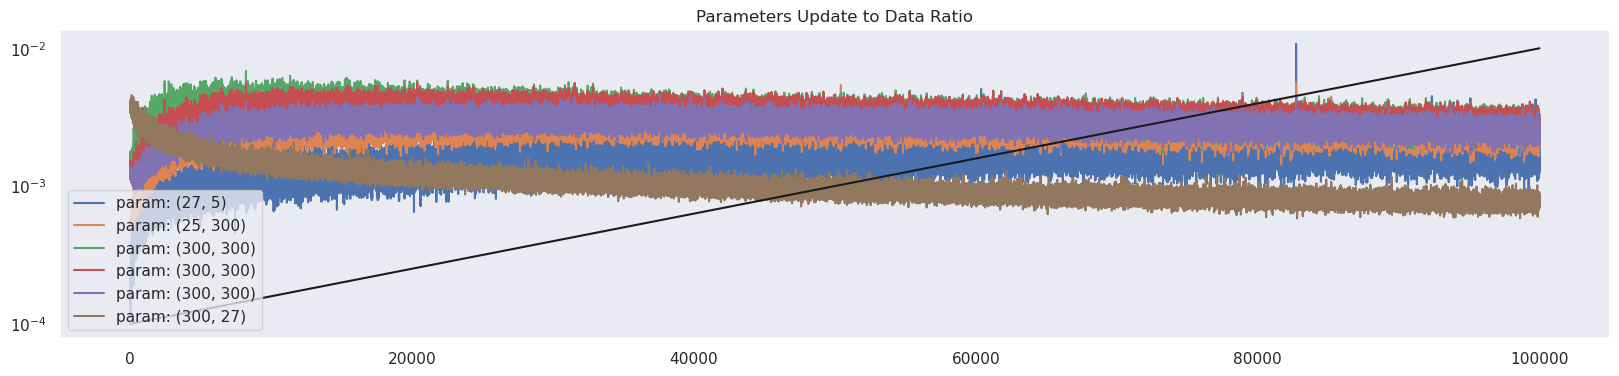

In [32]:
# visualize the update to parameters ratio
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
     # for simpilicity, just looking at 2d parameters meaning W in Linear
     # so skip bias, bn_shift, bn_scale
    if p.ndim == 2:
        # NSTEPS * NPARAMS
        plt.semilogy( [upd_param_ratio[j][i] for j in range(DEBUG_ITERS)] )
        legends.append(f'param: {tuple(p.shape)}')
plt.semilogy([0, DEBUG_ITERS], [1e-4, 1e-2], 'k') # these ratios should be around ~1e-3, plot this black line to indicate on plot
plt.legend(legends)
plt.title('Parameters Update to Data Ratio')
plt.show()

Now, if you change the weight gains in linear layers none of the above plots would change drastically, except update / data ratio. 

This means **`you still better off keep the recommended weight initialization to have a roughly equal training speed among all layers or adjust the learning rate consequently to have 1e-3 ratio for all layers`**.

But we are way more robust in training even if we change the gain and eliminate the root2(fan-in)

## Hyperparameter Tuning

1- if the training loss is roughly equal (.2f) to the dev loss, it means the model is under-fitted. it's not big enough to just purely memorizes the data. so we can scale the model and increase the number of parameters, meaning the size of hidden layer and embeddings.

2- On the other side, if your overfitting to traing data set, it means the model is to big and over-parameterized. so you have 2 options find a larger dataset, or lower the number of parameters.

Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [15]:
EMB_DIM = 3
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g)
b2 = torch.randn( NCLASS, generator=g)
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

10881

### increasing the size of Embeddings
Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [50]:
lri = []
lr_expo = torch.linspace(start=-3, end=0, steps=1000)
exponential_lr = 10**lr_expo

BATCH_SIZE = 32
loglossi = []
stepi = []

NSTEPS = 10000

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    # counts = logits.exp() # * equivalent to counts [b, NCLASS]
    # probs = counts / counts.sum(dim=1 , keepdim=True) #[b, NCLASS]
     
    # loss = -probs[torch.arange(BATCH_SIZE), ys].log().mean() + l2coef*(W**2).mean()

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    
    loglossi.append(loss_mini.log10().item())
    stepi.append(i)

    lr = exponential_lr[i]
    lri.append(lr_expo[i]) # store the exponent

    loss_mini.backward()

    # update &
    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # print(f'iteration: {i} | loss: {loss.item()}')

print(f'loss_mini: {loss_mini.item()}')

loss_mini: 1.905316710472107


In [ ]:
evaluate_loss('train')
evaluate_loss('dev')

In [ ]:
plt.plot(lri, loglossi)

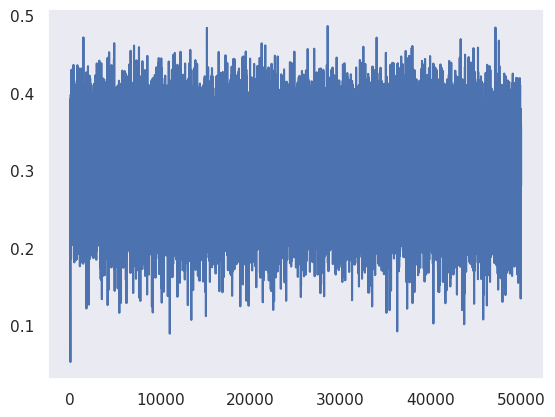

In [51]:
plt.plot(stepi, loglossi)

## Let's Generate some samples like Bigram

In [39]:

g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
    idx_y = 0
    name = ''
    context_window = [0]*WINDOW_SIZE
    
    while True:
        # Forward path
        emb = emb_lkt[torch.tensor([context_window])] # BATCH_SIZE=1, WINDOW_SIZE, emb_dim
        x = emb.view(-1, WINDOW_SIZE*EMB_DIM)
        
        for layer in layers:
            if isinstance(layer, BatchNorm1d):
                layer.training = False
        
        # Forward pass
        for layer in layers:
            x = layer(x)
        probs = F.softmax(x, dim=1)
        
        idx_y = torch.multinomial(probs.detach(), num_samples=1, replacement=True, generator=g).item()
        # shift_to_left context window and append the idx_y
        context_window = context_window[1:] + [idx_y]
        if idx_y == 0:
            break
        ch = i_to_s[idx_y]
        # print(ch)
        name += ch
    print(name)

mira
tychlinn
ssyler
komera
raka
marygnw
ronar
ciera
benhon
hannon
